In [1]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, sqlite3, pickle, time, datetime, random

# 0 Load Data

In [2]:
t = time.time()
path  = r'/rfs/CAPAI_PhD_dflr2/dflr2/Codes_Data_2/Data/'
file1 = path + '20210525_admissions.txt' 
file2 = path + '20210525_eobs.txt'
file3 = path + '20210525_haem-results.txt'
file4 = path + '20210525_icu.txt'
file5 = path + '20210525_meds.txt'
file6 = path + '20210525_micro-results.txt'
file7 = path + '20210525_oxygen.txt'
file8 = path + '20210525_prev_admissions.txt'
file9 = path + '20210525_spin.txt'
df_admin = pd.read_csv(file1, sep='\t', lineterminator='\n')
df_eobs  = pd.read_csv(file2, sep='\t', lineterminator='\n')
df_haemt = pd.read_csv(file3, sep='\t', lineterminator='\n')
df_icu   = pd.read_csv(file4, sep='\t', lineterminator='\n')
df_meds  = pd.read_csv(file5, sep='\t', lineterminator='\n')
df_micro = pd.read_csv(file6, sep='\t', lineterminator='\n')
df_oxyge = pd.read_csv(file7, sep='\t', lineterminator='\n')
df_prev  = pd.read_csv(file8, sep='\t', lineterminator='\n')
df_spin  = pd.read_csv(file9, sep='\t', lineterminator='\n')

/local/dlr10/ipykernel_26400/30948854.py:17: DtypeWarning: Columns (10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_micro = pd.read_csv(file6, sep='\t', lineterminator='\n')
/local/dlr10/ipykernel_26400/30948854.py:18: DtypeWarning: Columns (9,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_oxyge = pd.read_csv(file7, sep='\t', lineterminator='\n')


In [3]:
##############################################################################
#######################################
### Relevant fields for pre-processing
#######################################
reference_date = datetime.datetime(1970,1,1)

##### Fields in table patients ##########
patient_field         = 'patient_id'
age_field             = 'age_at_admission\r'
sex_field             = 'sex'
ethnic_field          = 'ethnic_origin'
death_ind_field       = 'death_indicator'
death_date_field      = 'date_of_death'
death_date_code_field = 'date_code_of_death'
mort_in_hosp_field    = 'Thirty_day_mort'
patients_cols = [patient_field,sex_field, ethnic_field, death_ind_field, death_date_field, death_date_code_field, 
                 mort_in_hosp_field]

##### Fields in table admissions ########
admission_field           = 'admission_id'
diagnosis_field           = 'episode_diagnoses'
admn_date_field           = 'admission_date_time'
admn_discharge_field      = 'discharge_date_time'
admn_date_code_field      = 'admission_date_code_time'
admn_discharge_code_field = 'discharge_date_code_time'
lengthofstay_field        = 'lengthofstay'
isPneumonia_field         = 'isPneumonia'
mortal_admin_field        = 'mortal_admin'
comorbidity_field         = 'Comorbidity_score'
icu_admin_field           = 'icu_count\r'
no_eobs_field             = 'no_obs_eobs'

 ##### Fields in table eObservations #####
eObs_time_field      = 'timestamp'
eObs_time_code_field = 'timestamp_code'
eObs_time_prev_obs   = 'time_since_prev_obs_in_mins'
eObs_resprate_field  = 'rr'
eObs_sbp_field       = 'sbp'
eObs_dbp_field       = 'dbp'
eObs_newscore_field  = 'ews'
eObs_heartrate_field = 'heart_rate'
eObs_temptr_field    = 'temperature\r'
eObs_oxygen_field    = 'Oxygen_Saturation'

In [4]:
data = pickle.load( open('DataFrame_pickles/df_patients_admissions_2016_2018.pickle', 'rb'))
df_patients   = data[0]
df_admissions = data[1]

In [5]:
print('min admin date', df_admissions[admn_date_field].min(),' max admin date', df_admissions[admn_date_field].max())
print('min disch date', df_admissions[admn_discharge_field].min(),' max disch date', df_admissions[admn_discharge_field].max())
len(df_patients)

min admin date 2016-01-01 04:34:00  max admin date 2018-12-31 20:53:00
min disch date 2016-01-02 01:35:00  max disch date 2019-06-18 10:33:00


18104

In [6]:
df_eobs.head(3)

,admission_id,patient_id,timestamp,time_since_arrival_in_hosp_mins,time_since_prev_obs_in_mins,rr,bp,ews,heart_rate,temperature\r
0,85761341,15274645,2018-05-30 20:54:20,NaN,NaN,18,93/42,3,109,36.1\r
1,85761341,15274645,2018-05-30 21:57:55,NaN,63.0,18,109/53,2,105,36.1\r
2,85761341,15274645,2018-05-31 12:24:09,NaN,NaN,18,95/55,3,108,37.7\r


In [7]:
df_eobs[eObs_time_field]      = pd.to_datetime(df_eobs[eObs_time_field], format='%Y-%m-%d %H:%M:%S')
df_eobs[eObs_time_code_field] = df_eobs[eObs_time_field] - reference_date
df_eobs[eObs_time_code_field] = df_eobs[eObs_time_code_field].apply(lambda x: x.days + (x.seconds/(24*3600)))

# 1. Processing eObs

In [8]:
t = time.time()

print("Initial number of readings in table", len(df_eobs))
df_eobs = df_eobs.drop_duplicates(keep='first')
print("Number of readings after removing duplciates",len(df_eobs))
# bp processing
bps = list(zip(*[tuple(x.split('/')) if len(tuple(x.split('/'))) == 2 else (np.nan,np.nan) for x in df_eobs['bp'].tolist()]))
df_eobs[eObs_sbp_field]       = np.array([float(x) for x in bps[0]])
df_eobs[eObs_dbp_field]       = np.array([float(x) for x in bps[1]])
# Heart rate processing
df_eobs[eObs_heartrate_field] = df_eobs[eObs_heartrate_field].apply(lambda x:float(x.replace('\r','')) if len(x.replace('\r',''))<5 else np.nan )
# Temperature processing
df_eobs[eObs_temptr_field]    = df_eobs[eObs_temptr_field].apply(lambda x: float(x.replace('\r','')) if len(x.replace('\r',''))<5 else np.nan)
df_eobs = df_eobs.drop(columns = ['time_since_arrival_in_hosp_mins','bp'])
print('')
print('time elapsed: ', time.time() - t)
df_eobs.dtypes

Initial number of readings in table 1137194
Number of readings after removing duplciates 1137181

time elapsed:  6.880551099777222


admission_id                            int64
patient_id                              int64
timestamp                      datetime64[ns]
time_since_prev_obs_in_mins           float64
rr                                      int64
ews                                     int64
heart_rate                            float64
temperature\r                         float64
timestamp_code                        float64
sbp                                   float64
dbp                                   float64
dtype: object

In [9]:
# Delete all the admissions and patients that do not have information in eObs

A= df_eobs[admission_field].unique().tolist()
print('Number of total admissions in eObs table', len(A))
list_admissions = df_admissions[admission_field].unique().tolist()
print('Number of total admissions in admissions table',len(list_admissions))
C = list(set(A) & set(list_admissions))
print('Number of total admissions in eObs and admissions tables',len(C))
print('')

#Redefinition of admissions table
df_admissions = df_admissions[df_admissions[admission_field].isin(C)].copy()
#Redefinition of list_admissions
list_admissions = df_admissions[admission_field].unique().tolist()
print('NEW number of total admissions in admissions table',len(list_admissions))
print('')

#Redefinition of patients table
df_patients = df_patients[df_patients[patient_field].isin(df_admissions[patient_field].unique())]
print('NEW number of total patients in admissions table',len(df_admissions[patient_field].unique().tolist()))
print('NEW number of total patients in patients table',len(df_patients[patient_field].unique().tolist()))

Number of total admissions in eObs table 18537
Number of total admissions in admissions table 23040
Number of total admissions in eObs and admissions tables 18537

NEW number of total admissions in admissions table 18537

NEW number of total patients in admissions table 14946
NEW number of total patients in patients table 14946


In [10]:
##################################
# Sorting the eObs set by time
t = time.time()
df_eobs_new = pd.DataFrame()
df_eobs[eObs_time_field] = pd.to_datetime(df_eobs[eObs_time_field], format='%Y-%m-%d %H:%M:%S')
for k, admission in enumerate(list_admissions):
    df_new_temp = df_eobs[df_eobs[admission_field] == admission].sort_values(by= eObs_time_field)
    df_new_temp.at[df_new_temp.index[0],eObs_time_prev_obs] = 0
    for i in range(1, len(df_new_temp)):
        df_new_temp.at[df_new_temp.index[i],eObs_time_prev_obs] = df_new_temp.iloc[i][eObs_time_field] - df_new_temp.iloc[i-1][eObs_time_field]
    df_eobs_new = pd.concat([df_eobs_new, df_new_temp])    
print('elapsed: ', time.time()-t)   

elapsed:  962.4759714603424


In [11]:
len(df_eobs_new)

1137181


# 2. Processing Oxygen Table

merging all the oxygen saturation values in the same column and then adding this column to eObs table

### 2.1. Process Oxygen table

In [12]:
A = df_oxyge[admission_field].unique().tolist()
print('Number of total admissions in Oxygen table', len(A))

print('Number of total admissions in admissions table',len(list_admissions))
C = list(set(A) & set(list_admissions))
print('Number of total admissions in oxyge and admissions tables',len(C))
print('')
B = df_eobs_new[admission_field].unique().tolist()
print('Number of total admissions in eObs table', len(B))

Number of total admissions in Oxygen table 18539
Number of total admissions in admissions table 18537
Number of total admissions in oxyge and admissions tables 18537

Number of total admissions in eObs table 18537


In [13]:
display(df_oxyge.groupby(['oxygen_device']).size())
df_oxyge['Assisted_O2'] = df_oxyge['oxygen_device'].apply(lambda x: 0 if x == 'Air' else 1)
display(df_oxyge.groupby(['Assisted_O2']).size())
df_oxyge.head(3)

oxygen_device
A=Air                           681749
Air                              22521
CH=Cold Humidification           17492
CP=CPAP                           4419
CPAP                               116
CPAP/NIPPV                          12
Cold Humidification                785
FM=Face Mask                       371
Face Mask Type Device               20
H=Humidified                      3675
HF=High Flow                     20002
High Flow                          543
N=Nasal Cannulae                 45350
NIV=Non invasive Ventilation     15049
NOF=Nasal Optiflow                 195
NRM=Non ReBreathe Mask            9065
NS=Nasal Specs                  250419
Nasal Cannula Type Device           19
Nasal Optiflow                       1
Nasal Specs                      10180
Neb=Nebuliser                     2373
Nebuliser                          166
Non Breathable Mask                 30
Non ReBreathe Mask                 304
Non invasive Ventilation           545
None       

Assisted_O2
0      22521
1    1123468
dtype: int64

,admission_id,patient_id,timestamp,oxygen_device,inspired_o2,inspired_o2_units,o2_sats,o2_sats_units,o2_saturations,o2_saturations_units,spo2,spo2_units,receiving_o2,receiving_o2_units,cap_refill\r,Assisted_O2
0,65644714,30278306,2019-01-28 15:46:17,Nasal Specs,2,litres,96,%,NaN,NaN,NaN,NaN,NaN,NaN,\r,1
1,43891608,43119506,2019-01-28 16:03:31,Air,Air,NaN,96,%,NaN,NaN,NaN,NaN,NaN,NaN,\r,0
2,43891608,43119506,2019-01-28 17:20:25,Air,Air,NaN,96,%,NaN,NaN,NaN,NaN,NaN,NaN,\r,0


### 2.2. Merge the information in 02_saturation and 02_stats columns

In [14]:
the_nulls = df_oxyge['o2_saturations'].isnull().sum()
the_fills = df_oxyge['o2_saturations'].notnull().sum()
print('Oxygen table has', len(df_oxyge), 'rows')
print("")
print('o2_saturations')
print('In o2_saturations are', the_fills, 'not null values')
print('In o2_saturations are', the_nulls, 'null values')
print(the_fills, '+',the_nulls,'=', the_nulls+the_fills)
the_nulls = df_oxyge['o2_sats'].isnull().sum()
the_fills = df_oxyge['o2_sats'].notnull().sum()
print("")
print('o2_sats')
print('In o2_sats are', the_fills, 'not null values')
print('In o2_sats are', the_nulls, 'null values')
print(the_fills, '+',the_nulls,'=', the_nulls+the_fills)

Oxygen table has 1145989 rows

o2_saturations
In o2_saturations are 55 not null values
In o2_saturations are 1145934 null values
55 + 1145934 = 1145989

o2_sats
In o2_sats are 1145685 not null values
In o2_sats are 304 null values
1145685 + 304 = 1145989


In [15]:
# Merging both columns and changing to dtypes int
def cleaning_saturation_data(item):
    
    if (type(item) == int) or (type(item) == float) : new_value = item
    elif (type(item) == str)  and (item.strip().isnumeric()): new_value = int(item)
    elif (type(item) == str)  and any(x.isnumeric() for x in item):
        if re.search(r'[0-9]{,4}\-[0-9]{,4}', item):
            o2_range = re.search(r'[0-9]{,4}\-[0-9]{,4}', item).group(0)
            o2_range = [int(x) for x in o2_range.split('-')]
            new_value = np.array(o2_range).mean()
    else:
        new_value = np.nan
    return new_value    

df_oxyge['o2_sats_']        = df_oxyge['o2_sats'].apply(lambda x: cleaning_saturation_data(x))
df_oxyge['o2_saturations_'] = df_oxyge['o2_saturations'].apply(lambda x: cleaning_saturation_data(x))
df_oxyge[eObs_oxygen_field]      = df_oxyge.filter(['o2_sats_','o2_saturations_']).max(1)
print('total values that are null', df_oxyge[eObs_oxygen_field].isnull().sum(), ',values to be imputed')
print('values in Oxygen table', len(df_oxyge))
print('values in eobs', len(df_eobs))


total values that are null 10078 ,values to be imputed
values in Oxygen table 1145989
values in eobs 1137181


In [16]:
##################################
# Sorting the eObs set by time, getting the information 
t = time.time()
df_oxyge_new = pd.DataFrame()
df_oxyge[eObs_time_field] = pd.to_datetime(df_oxyge[eObs_time_field], format='%Y-%m-%d %H:%M:%S')

for k, admission in enumerate(list_admissions):
    df_new_temp = df_oxyge[df_oxyge[admission_field] == admission].sort_values(by= eObs_time_field)
    df_oxyge_new = pd.concat([df_oxyge_new, df_new_temp])    
print('elapsed: ', time.time()-t)   

elapsed:  1231.9116599559784


In [17]:
A = df_oxyge_new[admission_field].unique().tolist()
print('Number of total admissions in Oxygen table', len(A))

print('Number of total admissions in admissions table',len(list_admissions))
C = list(set(A) & set(list_admissions))
print('Number of total admissions in oxyge and admissions tables',len(C))
print('')
B = df_eobs_new[admission_field].unique().tolist()
print('Number of total admissions in eObs table', len(B))

Number of total admissions in Oxygen table 18537
Number of total admissions in admissions table 18537
Number of total admissions in oxyge and admissions tables 18537

Number of total admissions in eObs table 18537


# 3. Check and handle Outliers

In [18]:
df_eobs_new.describe()

,admission_id,patient_id,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
count,1.137181e+06,1.137181e+06,1.137181e+06,1.137181e+06,1.128912e+06,1.125489e+06,1.137181e+06,1.125088e+06,1.125088e+06
mean,5.006704e+07,4.989516e+07,1.886396e+01,2.194485e+00,8.503052e+01,3.685214e+01,1.747633e+04,1.239142e+02,6.975002e+01
std,2.860396e+07,2.880155e+07,3.220531e+00,2.280867e+00,1.676312e+01,6.006547e-01,2.528785e+02,2.168096e+01,1.407169e+01
min,1.694400e+04,1.284400e+04,1.000000e+00,0.000000e+00,1.000000e+01,2.800000e+01,1.680703e+04,3.100000e+01,0.000000e+00
25%,2.532123e+07,2.568424e+07,1.700000e+01,0.000000e+00,7.300000e+01,3.650000e+01,1.725345e+04,1.090000e+02,6.100000e+01
50%,4.984638e+07,4.962199e+07,1.800000e+01,2.000000e+00,8.500000e+01,3.680000e+01,1.749855e+04,1.210000e+02,6.900000e+01
75%,7.502958e+07,7.476171e+07,2.000000e+01,3.000000e+00,9.400000e+01,3.720000e+01,1.768177e+04,1.370000e+02,7.800000e+01
max,9.999497e+07,9.999568e+07,9.900000e+01,2.200000e+01,2.570000e+02,4.200000e+01,1.806536e+04,2.880000e+02,2.920000e+02


In [19]:
df_eobs_new.isna().sum()

admission_id                       0
patient_id                         0
timestamp                          0
time_since_prev_obs_in_mins        0
rr                                 0
ews                                0
heart_rate                      8269
temperature\r                  11692
timestamp_code                     0
sbp                            12093
dbp                            12093
dtype: int64

In [20]:
dict_labels = {'rr':'Respiratory rate','ews':'EWS','heart_rate':'Heart rate','temperature\r':'Temperature',
               'sbp':'Systolic bp','dbp':'Diastolic bp','Oxygen_Saturation':'Oxygen Saturation','Assisted_O2':'Assisted O2',
               'Confusion':'Confusion','CREA':'Creatinine','UREA':'Urea','K':'Potassium', 'GFR':'GFR','WBC':'WBC',
               'PLT':'Platelets','HCT':'HCT','HGB':'Haemoglobin','RBC':'RBC','MCH':'MCH','MCV':'MCV','NEUAB':'Neutrophil Ab',
               'TLYMAB':'T-lymphocite Ab','EOSAB':'EOS Ab','MONAB':'Monocyte Ab','BASAB':'Anti Basophil Ab','ALB':'Albumin',
               'ALP':'Alk. Phosphate','BILI':'Bilirubin','sex':'Sex','ethnicity':'Ethnicity','had_Prev_admin':'Prev. admission',
               'age_at_admin':'Age at admission','Comorb_score':'Charlson comorbid.','Spcfc_Comorb':'Resp. Comorbidity'}

dict_sypmt_min_max = {'rr':[5, 40], 'heart_rate':[20,160], 'temperature\r':[30, 45],'sbp': [60,200], 'dbp':[40,120],
                 'Oxygen_Saturation':[60,100], 'ews':[0,21]}

In [63]:
import random
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import matplotlib.pyplot as plt

def handling_errors(field, df_eobs_new,dict_sypmt_min_max, save = False):
    n_plots = 4
    print(field)
    print("Values na in " + field,df_eobs_new[field].isna().sum())
    min_b = dict_sypmt_min_max[field][0]
    max_b = dict_sypmt_min_max[field][1]
    adm_withmin = df_eobs_new[min_b > df_eobs_new[field]]['admission_id'].unique().tolist()
    adm_withmax = df_eobs_new[df_eobs_new[field] > max_b]['admission_id'].unique().tolist()
    adms_plot   = adm_withmin + adm_withmax
    field_max = df_eobs_new[field].max()

    n_outliers = len(df_eobs_new[(min_b > df_eobs_new[field]) | (df_eobs_new[field] > max_b)])
    
    print('Number of admissions that will change:', len(adms_plot) )    
    print('Number of records out of limits:', n_outliers)
    
    if len(adms_plot) == 0 : 
        print("No values to fix")
        return df_eobs_new
    if len(adms_plot) <= n_plots: adm_idxs    = range(len(adms_plot))
    else:                   adm_idxs    = random.sample(range(len(adms_plot)), n_plots)

    df_eobs_new2 = df_eobs_new.copy()
    df_eobs_new2[field] = df_eobs_new2[field].apply(lambda x: np.nan if x!=x else x if (min_b <= x) and (x <= max_b) 
                                                    else min_b if x < min_b else max_b)
    n_outliers2 = len(df_eobs_new2[(min_b > df_eobs_new2[field]) | (df_eobs_new2[field] > max_b)])
    
    print("Percentage of admins modified for " + field, "from", len(df_eobs_new2['admission_id'].unique()), 
          "is {:0.2f}".format(len(adms_plot)*100/len(df_eobs_new2['admission_id'].unique())), "%")
    print("Percentage of records modified for " + field, "from", len(df_eobs_new2), 
          "is {:0.2f}".format(n_outliers*100/len(df_eobs_new2)), "%")

    fig = plt.figure(figsize = (25,5))

    for i,idx_adm in enumerate(adm_idxs):
        adm_ = adms_plot[idx_adm]    
        x = df_eobs_new[df_eobs_new[admission_field] == adm_]['timestamp'].tolist()
        x1 = np.arange(0, len(x), 1)
        y = df_eobs_new[df_eobs_new[admission_field] == adm_][field]

        xt = df_eobs_new2[df_eobs_new2[admission_field] == adm_]['timestamp']
        xt1 = np.arange(0, len(xt), 1)
        yt = df_eobs_new2[df_eobs_new2[admission_field] == adm_][field]

        ax = fig.add_subplot(1, n_plots, i+1)
        ax.plot(x1,y, 'b-.', label = 'Original')
        ax.plot(xt1,yt, 'r-', label = 'Processed')
        
        ax.plot(x1, np.ones(len(x1)) * max_b, '--', color = 'orange')
        ax.plot(x1, np.ones(len(x1)) * min_b, '--', color = 'orange')
        
        ax.tick_params(labelsize =22)
        ax.set_ylim((min_b *0.75,max_b +  (field_max-max_b)*0.3))
        ax.set_title('admission ' + str(adm_), fontsize = 25)
        
    fig.text(0.08, 0.5, dict_labels[field], va='center', rotation='vertical', fontsize = 30)
    plt.legend(fontsize = 20, loc = 'upper right', frameon=False, framealpha = 0.4)
    if save == True: 
        plt.savefig(r'Images/Train_HandlingOutliersExample_'+ field +'.png', transparent = True, bbox_inches = "tight")
    plt.show()
    return df_eobs_new2

### Handle Outliers of Eobs

rr
Values na in rr 0
Number of admissions that will change: 654
Number of records out of limits: 1596
Percentage of admins modified for rr from 18537 is 3.53 %
Percentage of records modified for rr from 1137181 is 0.14 %


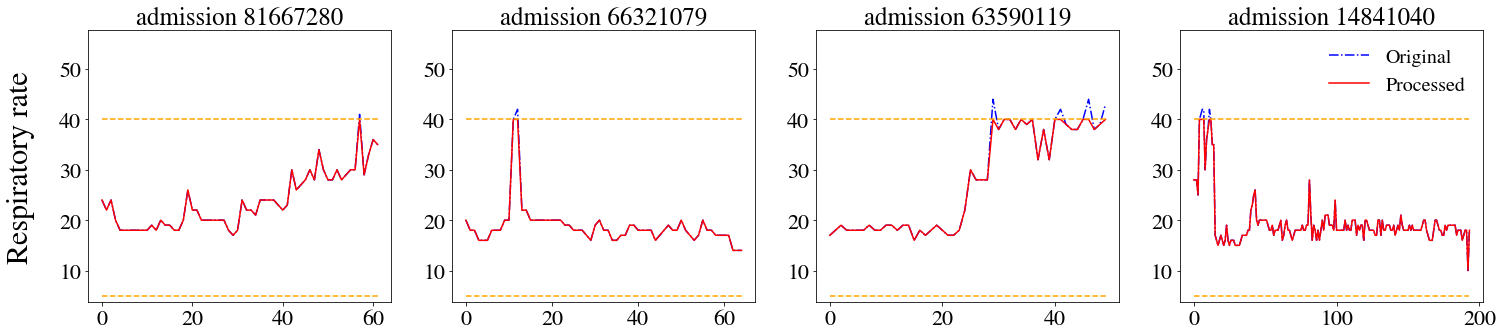

In [64]:
df_eobs_new2 = handling_errors('rr', df_eobs_new, dict_sypmt_min_max, save = True)

ews
Values na in ews 0
Number of admissions that will change: 1
Number of records out of limits: 1
Percentage of admins modified for ews from 18537 is 0.01 %
Percentage of records modified for ews from 1137181 is 0.00 %


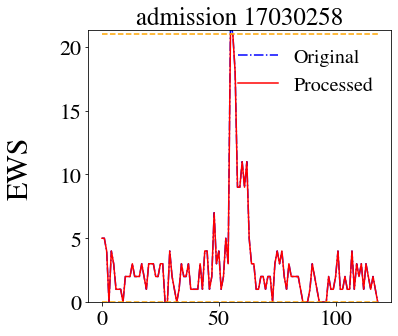

In [65]:
df_eobs_new2 = handling_errors('ews', df_eobs_new2, dict_sypmt_min_max, save = True)

heart_rate
Values na in heart_rate 8269
Number of admissions that will change: 467
Number of records out of limits: 1076
Percentage of admins modified for heart_rate from 18537 is 2.52 %
Percentage of records modified for heart_rate from 1137181 is 0.09 %


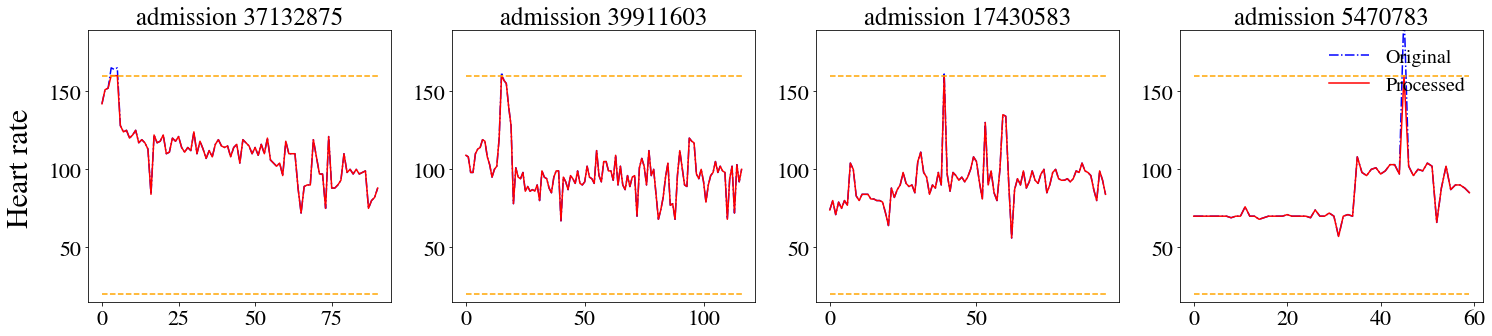

In [66]:
df_eobs_new2 = handling_errors('heart_rate', df_eobs_new2, dict_sypmt_min_max, save = True)

temperature
 11692 na in temperature
Number of admissions that will change: 13
Number of records out of limits: 24
 from 18537 is 0.07 %modified for temperature
 from 1137181 is 0.00 %odified for temperature


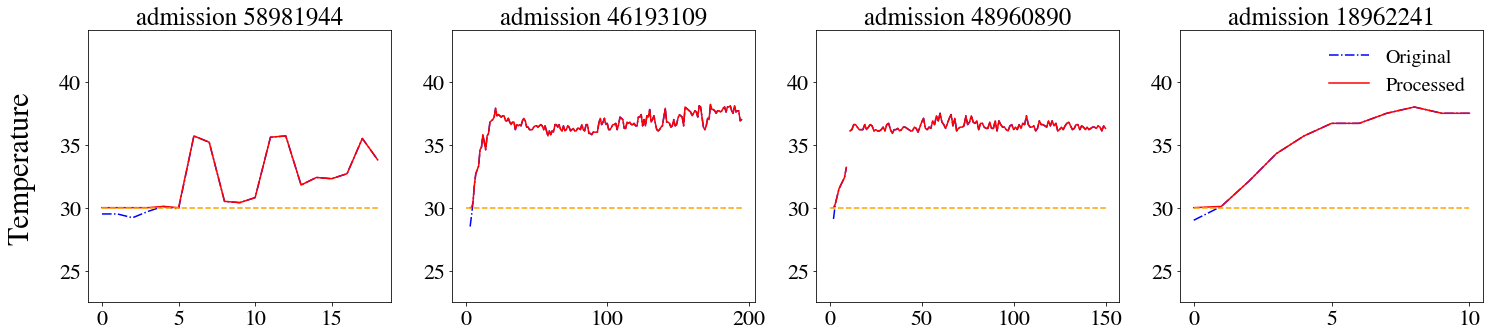

In [67]:
df_eobs_new2 = handling_errors('temperature\r', df_eobs_new2, dict_sypmt_min_max, save = True)

sbp
Values na in sbp 12093
Number of admissions that will change: 1081
Number of records out of limits: 2444
Percentage of admins modified for sbp from 18537 is 5.83 %
Percentage of records modified for sbp from 1137181 is 0.21 %


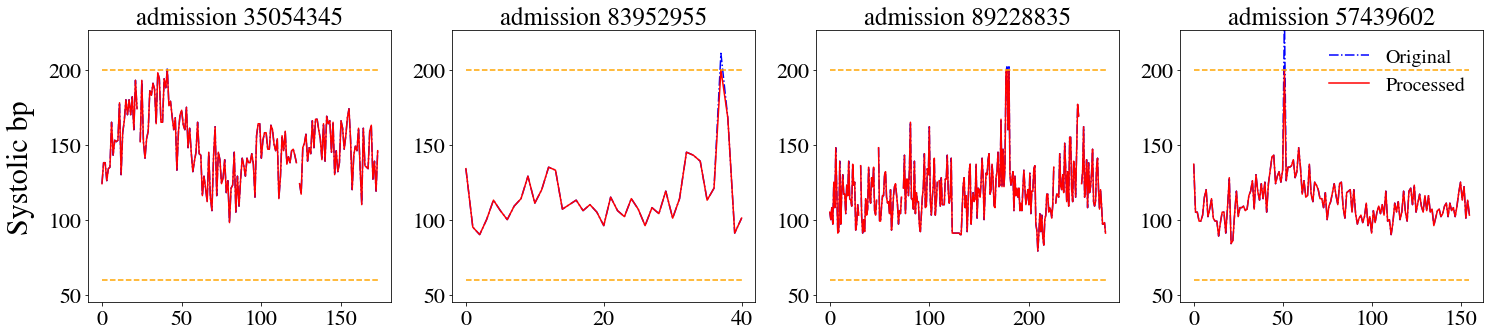

In [68]:
df_eobs_new2 = handling_errors('sbp', df_eobs_new2, dict_sypmt_min_max, save = True)

dbp
Values na in dbp 12093
Number of admissions that will change: 7223
Number of records out of limits: 14199
Percentage of admins modified for dbp from 18537 is 38.97 %
Percentage of records modified for dbp from 1137181 is 1.25 %


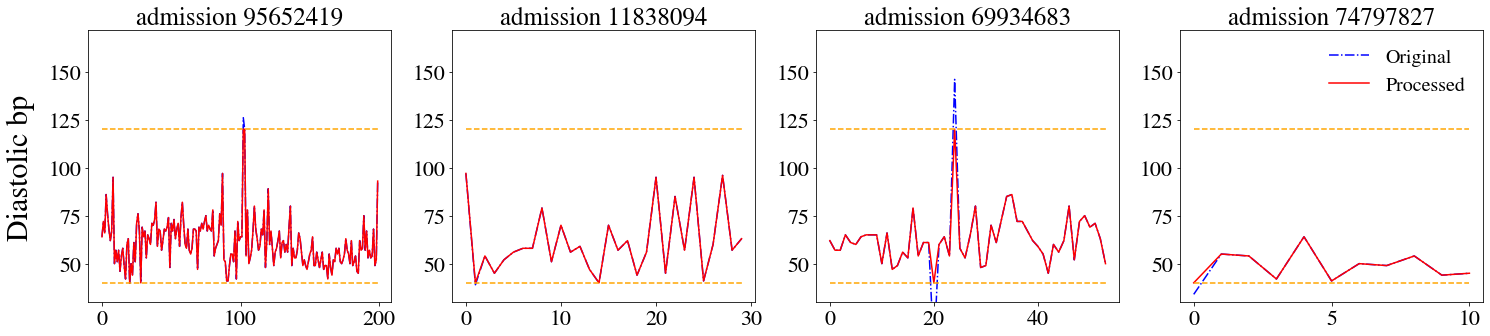

In [69]:
df_eobs_new2 = handling_errors('dbp', df_eobs_new2, dict_sypmt_min_max, save = True)

In [28]:
display(df_eobs_new.describe())
display(df_eobs_new2.describe())

,admission_id,patient_id,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
count,1.137181e+06,1.137181e+06,1.137181e+06,1.137181e+06,1.128912e+06,1.125489e+06,1.137181e+06,1.125088e+06,1.125088e+06
mean,5.006704e+07,4.989516e+07,1.886396e+01,2.194485e+00,8.503052e+01,3.685214e+01,1.747633e+04,1.239142e+02,6.975002e+01
std,2.860396e+07,2.880155e+07,3.220531e+00,2.280867e+00,1.676312e+01,6.006547e-01,2.528785e+02,2.168096e+01,1.407169e+01
min,1.694400e+04,1.284400e+04,1.000000e+00,0.000000e+00,1.000000e+01,2.800000e+01,1.680703e+04,3.100000e+01,0.000000e+00
25%,2.532123e+07,2.568424e+07,1.700000e+01,0.000000e+00,7.300000e+01,3.650000e+01,1.725345e+04,1.090000e+02,6.100000e+01
50%,4.984638e+07,4.962199e+07,1.800000e+01,2.000000e+00,8.500000e+01,3.680000e+01,1.749855e+04,1.210000e+02,6.900000e+01
75%,7.502958e+07,7.476171e+07,2.000000e+01,3.000000e+00,9.400000e+01,3.720000e+01,1.768177e+04,1.370000e+02,7.800000e+01
max,9.999497e+07,9.999568e+07,9.900000e+01,2.200000e+01,2.570000e+02,4.200000e+01,1.806536e+04,2.880000e+02,2.920000e+02


,admission_id,patient_id,rr,ews,heart_rate,temperature\r,timestamp_code,sbp,dbp
count,1.137181e+06,1.137181e+06,1.137181e+06,1.137181e+06,1.128912e+06,1.125489e+06,1.137181e+06,1.125088e+06,1.125088e+06
mean,5.006704e+07,4.989516e+07,1.885553e+01,2.194484e+00,8.501981e+01,3.685216e+01,1.747633e+04,1.238938e+02,6.985840e+01
std,2.860396e+07,2.880155e+07,3.135099e+00,2.280860e+00,1.670415e+01,6.004184e-01,2.528785e+02,2.158675e+01,1.333612e+01
min,1.694400e+04,1.284400e+04,5.000000e+00,0.000000e+00,2.000000e+01,3.000000e+01,1.680703e+04,6.000000e+01,4.000000e+01
25%,2.532123e+07,2.568424e+07,1.700000e+01,0.000000e+00,7.300000e+01,3.650000e+01,1.725345e+04,1.090000e+02,6.100000e+01
50%,4.984638e+07,4.962199e+07,1.800000e+01,2.000000e+00,8.500000e+01,3.680000e+01,1.749855e+04,1.210000e+02,6.900000e+01
75%,7.502958e+07,7.476171e+07,2.000000e+01,3.000000e+00,9.400000e+01,3.720000e+01,1.768177e+04,1.370000e+02,7.800000e+01
max,9.999497e+07,9.999568e+07,4.000000e+01,2.100000e+01,1.600000e+02,4.200000e+01,1.806536e+04,2.000000e+02,1.200000e+02


### Handle Outliers of Oxygen df

In [29]:
df_oxyge_new.describe()

,admission_id,patient_id,o2_saturations,spo2,spo2_units,Assisted_O2,o2_sats_,o2_saturations_,Oxygen_Saturation
count,1.145963e+06,1.145963e+06,29.000000,0.0,0.0,1.145963e+06,1.135856e+06,29.000000,1.135885e+06
mean,5.007371e+07,4.990195e+07,97.517241,NaN,NaN,9.803475e-01,9.567879e+01,97.517241,9.567884e+01
std,2.860111e+07,2.879702e+07,2.028734,NaN,NaN,1.388030e-01,2.969195e+00,2.028734,2.969189e+00
min,1.694400e+04,1.284400e+04,93.000000,NaN,NaN,0.000000e+00,5.000000e+01,93.000000,5.000000e+01
25%,2.532421e+07,2.574565e+07,96.000000,NaN,NaN,1.000000e+00,9.500000e+01,96.000000,9.500000e+01
50%,4.985468e+07,4.963718e+07,98.000000,NaN,NaN,1.000000e+00,9.600000e+01,98.000000,9.600000e+01
75%,7.504225e+07,7.476171e+07,99.000000,NaN,NaN,1.000000e+00,9.700000e+01,99.000000,9.700000e+01
max,9.999497e+07,9.999568e+07,100.000000,NaN,NaN,1.000000e+00,1.000000e+02,100.000000,1.000000e+02


Oxygen_Saturation
Values na in Oxygen_Saturation 10078
Number of admissions that will change: 74
Number of records out of limits: 83
Percentage of admins modified for Oxygen_Saturation from 18537 is 0.40 %
Percentage of records modified for Oxygen_Saturation from 1145963 is 0.01 %


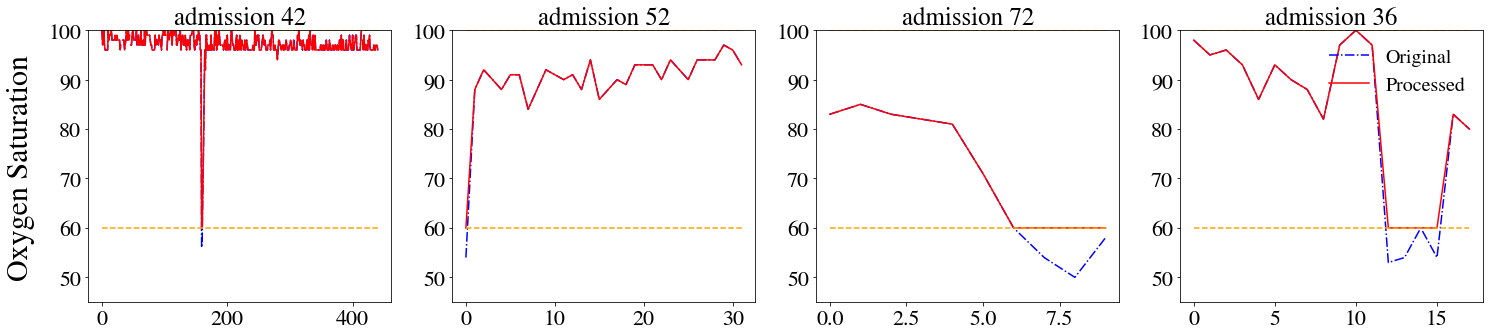

In [30]:
df_oxyge_new2 = handling_errors('Oxygen_Saturation', df_oxyge_new, dict_sypmt_min_max, save = True)

In [31]:
display(df_oxyge_new.describe())
display(df_oxyge_new2.describe())

,admission_id,patient_id,o2_saturations,spo2,spo2_units,Assisted_O2,o2_sats_,o2_saturations_,Oxygen_Saturation
count,1.145963e+06,1.145963e+06,29.000000,0.0,0.0,1.145963e+06,1.135856e+06,29.000000,1.135885e+06
mean,5.007371e+07,4.990195e+07,97.517241,NaN,NaN,9.803475e-01,9.567879e+01,97.517241,9.567884e+01
std,2.860111e+07,2.879702e+07,2.028734,NaN,NaN,1.388030e-01,2.969195e+00,2.028734,2.969189e+00
min,1.694400e+04,1.284400e+04,93.000000,NaN,NaN,0.000000e+00,5.000000e+01,93.000000,5.000000e+01
25%,2.532421e+07,2.574565e+07,96.000000,NaN,NaN,1.000000e+00,9.500000e+01,96.000000,9.500000e+01
50%,4.985468e+07,4.963718e+07,98.000000,NaN,NaN,1.000000e+00,9.600000e+01,98.000000,9.600000e+01
75%,7.504225e+07,7.476171e+07,99.000000,NaN,NaN,1.000000e+00,9.700000e+01,99.000000,9.700000e+01
max,9.999497e+07,9.999568e+07,100.000000,NaN,NaN,1.000000e+00,1.000000e+02,100.000000,1.000000e+02


,admission_id,patient_id,o2_saturations,spo2,spo2_units,Assisted_O2,o2_sats_,o2_saturations_,Oxygen_Saturation
count,1.145963e+06,1.145963e+06,29.000000,0.0,0.0,1.145963e+06,1.135856e+06,29.000000,1.135885e+06
mean,5.007371e+07,4.990195e+07,97.517241,NaN,NaN,9.803475e-01,9.567879e+01,97.517241,9.567923e+01
std,2.860111e+07,2.879702e+07,2.028734,NaN,NaN,1.388030e-01,2.969195e+00,2.028734,2.964024e+00
min,1.694400e+04,1.284400e+04,93.000000,NaN,NaN,0.000000e+00,5.000000e+01,93.000000,6.000000e+01
25%,2.532421e+07,2.574565e+07,96.000000,NaN,NaN,1.000000e+00,9.500000e+01,96.000000,9.500000e+01
50%,4.985468e+07,4.963718e+07,98.000000,NaN,NaN,1.000000e+00,9.600000e+01,98.000000,9.600000e+01
75%,7.504225e+07,7.476171e+07,99.000000,NaN,NaN,1.000000e+00,9.700000e+01,99.000000,9.700000e+01
max,9.999497e+07,9.999568e+07,100.000000,NaN,NaN,1.000000e+00,1.000000e+02,100.000000,1.000000e+02


# 4. Modification of Admissions DataFrame

### 4.1. Adding Number of e-observation to each admission

In [32]:
t = time.time()
admin_obs = []
for adm in df_admissions[admission_field]:    
    admin_obs.append(len(df_eobs_new2[df_eobs_new2[admission_field] == adm]))

df_admissions.at[:,[no_eobs_field]] = admin_obs

print('times elapsed: ',time.time() - t)
df_admissions.head(3)

times elapsed:  23.05389904975891


,admission_id,episode_diagnoses,patient_id,age_at_admission\r,admission_date_time,admission_date_code_time,discharge_date_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score,no_obs_eobs
1,7763466,"||J18.1,J84.9,C34.9,R26.8,E11.9,R15.X,R32.X,H91.9",68825097,90,2017-10-26 05:36:00,17465.233333,2017-10-26 17:59:00,17465.749306,0 days 12:23:00,1,0,0,3,10
2,58250780,"||J18.1,J44.0,C34.9,I71.4,R60.0,I73.9,Z92.1,I1...",68825097,91,2017-11-06 23:01:00,17476.959028,2017-11-09 05:50:00,17479.243056,2 days 06:49:00,1,1,0,15,20
4,92464775,"||J18.1,N17.9,F05.9,J90.X,R33.X,G20.X,R63.8,E1...",18544317,91,2018-03-11 18:20:00,17601.763889,2018-03-16 18:00:00,17606.750000,4 days 23:40:00,1,1,0,6,45


In [33]:
df_admissions.describe()

,admission_id,patient_id,age_at_admission\r,admission_date_code_time,discharge_date_code_time,lengthofstay,isPneumonia,mortal_admin,icu_count\r,Comorbidity_score,no_obs_eobs
count,1.853700e+04,1.853700e+04,18537.000000,18537.000000,18537.000000,18537,18537.000000,18537.000000,18537.000000,18537.000000,18537.000000
mean,4.976864e+07,5.002554e+07,72.859362,17468.792118,17481.217482,12 days 10:12:31.461401521,0.998112,0.207531,0.037600,4.071587,61.346550
std,2.873352e+07,2.884808e+07,16.648853,256.346850,256.033505,16 days 23:24:46.471802695,0.043413,0.405550,0.190233,5.447279,78.734849
min,1.694400e+04,1.284400e+04,16.000000,16806.750000,16817.583333,0 days 00:05:00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.485541e+07,2.530146e+07,65.000000,17240.980556,17252.656250,3 days 17:24:00,1.000000,0.000000,0.000000,0.000000,21.000000
50%,4.962365e+07,4.986023e+07,77.000000,17492.834028,17504.798611,7 days 16:05:00,1.000000,0.000000,0.000000,2.000000,40.000000
75%,7.456928e+07,7.503801e+07,85.000000,17677.562500,17689.812500,15 days 00:25:00,1.000000,0.000000,0.000000,6.000000,75.000000
max,9.999497e+07,9.999568e+07,113.000000,17896.870139,18065.439583,390 days 20:15:00,1.000000,1.000000,1.000000,117.000000,2064.000000


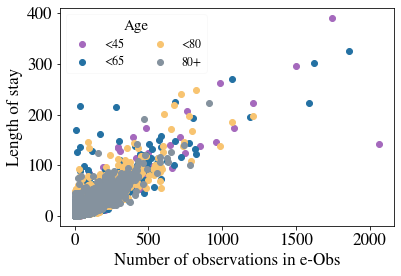

In [49]:
df_plot = df_admissions[['age_at_admission\r', 'lengthofstay', 'no_obs_eobs']].copy()
0

plt.scatter(df_plot[df_plot['age_group'] == 1]['no_obs_eobs'], df_plot[df_plot['age_group'] == 1]['lengthofstay'].dt.days, label = '<65', color = '#2471a3')
plt.scatter(df_plot[df_plot['age_group'] == 2]['no_obs_eobs'], df_plot[df_plot['age_group'] == 2]['lengthofstay'].dt.days, label = '<80', color = '#f8c471')
plt.scatter(df_plot[df_plot['age_group'] == 3]['no_obs_eobs'], df_plot[df_plot['age_group'] == 3]['lengthofstay'].dt.days, label = '80+', color = '#85929e')
plt.xlabel('Number of observations in e-Obs', fontsize = 17)
plt.ylabel('Length of stay', fontsize = 17)
plt.tick_params(labelsize = 17)
plt.legend( title = 'Age', title_fontsize = 15, fontsize = 12, frameon=True, framealpha = 0.1, ncol=2)
plt.savefig(r'Images/LoS_NumbereObs.png', transparent = True, bbox_inches = "tight")
plt.show()

### 4.2. Processing Ethnicity field to make it a numerical variable

In [35]:
A = df_patients[ethnic_field].unique().tolist()
print(A)
df_patients.loc[:,ethnic_field] = df_patients[ethnic_field].apply(lambda x: A.index(x))
print(df_patients[ethnic_field].unique().tolist())

['A', 'S', 'K', 'H', 'R', 'E', 'B', 'C', 'L', 'Z', 'J', 'P', 'M', 'F', 'N', 'G', 'D']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


/local/dlr10/ipykernel_26400/2537763513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patients.loc[:,ethnic_field] = df_patients[ethnic_field].apply(lambda x: A.index(x))


# 5. Pickle data

In [36]:
pickling_data = [df_patients, df_admissions]
pickle.dump(pickling_data, open('DataFrame_pickles/df_patients_admissions_2016_2018_v2.pickle', 'wb'))
pickling_data = [df_eobs_new2, df_oxyge_new2]
pickle.dump(pickling_data, open('DataFrame_pickles/df_eobs_oxygen_2016_2018_v2.pickle', 'wb'))

In [38]:
##############################
# Why the recorded CURB is not enough and treated differently?
##############################
print('number of patients in spin', len(df_spin[patient_field].unique().tolist()))
print('number of patients in patients', len(df_patients))
c = len(list(set(df_spin[patient_field].unique().tolist()) & set(df_patients[patient_field])))
print('number of patients in spin and patients', c)

df_spin.head(3)


number of patients in spin 6078
number of patients in patients 14946
number of patients in spin and patients 5316


,patient_id,date_time_arrived,cxr_4h,cxr_cap,cxr_date,cxr_time,o2_1h,o2_prescribed_1h,curb65_recorded,curb65_score,ab_4h,reason_ab_not_concordant,ab_severity,ab_date_time\r
0,22377059,2016-01-05 12:27:00,Y,Y,2015-01-05,15:35,Y,N,Y,2.0,Y,NaN,N,2016-01-05 12:50:00\r
1,83768183,2016-01-06 13:00:00,Y,Y,2016-01-06,14:53,Y,N,Y,0.0,Y,NaN,Y,2016-01-06 16:00:00\r
2,14436193,2016-01-06 18:59:00,Y,Y,2016-01-06,19:50,Y,N,Y,0.0,Y,NaN,Y,2016-01-06 18:00:00\r
